# Maspawio

## Dublin Core to Schema.org workflow testing

An experiment to see if we can convert a Dublin Core record to Schema.org.  The focus will be on OIH type https://book.oceaninfohub.org/thematics/docs/README.html


The source location is: https://maspawio.net/layers/geonode%3Alocally_managed_marine_areas_kenya 

Need somethnig like documented at: https://book.oceaninfohub.org/thematics/docs/maps.html   We will need to add into this a sptial geometry to scope the bounding box.

https://docs.google.com/spreadsheets/d/1OS_DPrPppxkWR7kU3vjRJaDSCq3XFn74/edit#gid=1139001206


## Note OIH Themtic mapping

What existing (or not) patterns do we align to


## Document Risk Pattens

* URI pattern (URI governance)
* Sitemap update patterns

## Steps to alignment with Structured Data on the Web

* ...


In [1]:
import json
from pyld import jsonld
import os, sys
import xml.etree.ElementTree as ET
from urllib.request import urlopen


# import rdflib
# from rdflib import Graph, plugin
# from rdflib.serializer import Serializer
# from icecream import ic
# from pathlib import Path


In [2]:
# Source Dubline core XML from net (https issue)
# Groups do need to start to move to https over http.  However, when doing so, the issue of geting and installing the certificate
# can be an impediment.  A popular group used by many is the Let's Encrypt group (https://letsencrypt.org/).  Reference their 
# documentation on CertBot (https://certbot.eff.org/)

# dcxml = "https://maspawio.net/catalogue/csw?outputschema=http%3A%2F%2Fwww.opengis.net%2Fcat%2Fcsw%2F2.0.2&service=CSW&request=GetRecordById&version=2.0.2&elementsetname=full&id=3046b5fc-18e0-11eb-894f-0a735f7a740c"
# with urlopen(dcxml) as f:
#     tree = ET.parse(f)
#     root = tree.getroot()

In [32]:
# Bypassing the issue of the https cert, use a local file downloaded by bypassing the warning. 
tree = ET.parse('./data/dublin.xml')
root = tree.getroot()
# print(root.tag)

In [33]:
r = root.find('{http://www.opengis.net/cat/csw/2.0.2}Record')

In [34]:
# Just a loop to inspect all the elements, normall commented out and not needed in final script
for element in r.findall('*'):
            print("{} :: {}".format(element.tag, element.text))

{http://purl.org/dc/elements/1.1/}identifier :: 3046b5fc-18e0-11eb-894f-0a735f7a740c
{http://purl.org/dc/elements/1.1/}title :: locally managed marine areas Kenya
{http://purl.org/dc/elements/1.1/}type :: dataset
{http://purl.org/dc/elements/1.1/}subject :: kenya
{http://purl.org/dc/elements/1.1/}subject :: LMMA
{http://purl.org/dc/elements/1.1/}format :: vector
{http://purl.org/dc/terms/}references :: http://maspawio.net/geoserver/geonode/wfs
{http://purl.org/dc/terms/}references :: http://maspawio.net/geoserver/geonode/wms
{http://purl.org/dc/terms/}references :: http://maspawio.net/geoserver/wms?request=GetLegendGraphic&format=image/png&WIDTH=20&HEIGHT=20&LAYER=geonode:locally_managed_marine_areas_kenya&legend_options=fontAntiAliasing:true;fontSize:12;forceLabels:on
{http://purl.org/dc/terms/}references :: http://maspawio.net/uploaded/thumbs/layer-3046b5fc-18e0-11eb-894f-0a735f7a740c-thumb.png
{http://purl.org/dc/terms/}references :: http://maspawio.net/geoserver/wms/reflect?layers=

# Type matching

In this case we see the type as "dataset" so we can match this to schema.org/Dataset.  Other types would need special 
paths.  

In [58]:
# id
id = r.find('{http://purl.org/dc/elements/1.1/}identifier')
print(id.text)

# name
# This can be used to form the URL:  https://maspawio.net/layers/geonode%3Alocally_managed_marine_areas_kenya
name = r.find('{http://purl.org/dc/elements/1.1/}title')
print(name.text)

# description
description = r.find('{http://purl.org/dc/terms/}abstract')
print(description.text)

# keywords
subjects = r.findall('{http://purl.org/dc/elements/1.1/}subject')
for s in subjects:
    print(s.text)

# spatial data
bb = r.find('{http://www.opengis.net/ows}BoundingBox')
uc = bb.find('{http://www.opengis.net/ows}UpperCorner')
lc = bb.find('{http://www.opengis.net/ows}LowerCorner')
ucs = uc.text.split(" ")
lcs = lc.text.split(" ")
x1 = float(ucs[0])
y1 = float(ucs[1])
x2 = float(lcs[0])
y2 = float(lcs[1])

# # 'POLYGON(x1 y1, x1 y2, x2 y2, x2 y1, x1 y1)'
poly = str("""POLYGON({}  {}  {}  {} {}  {}  {}  {} {} {})""".format(x1, y1, x1, y2, x2, y2, x2, y1, x1, y1))

print(poly)

# url https://maspawio.net/layers/geonode:locally_managed_marine_areas_kenya

3046b5fc-18e0-11eb-894f-0a735f7a740c
locally managed marine areas Kenya
This resource/layer shows the spatial location of locally managed marine areas (LMMA) along the Kenyan coast. The information comes from a report done by CORDIO in 2015 that sought to review a detailed history of LMMA development in Kenya. For more information, please contact jkawaka@cordioea.net


kenya
LMMA
POLYGON(-2.094547  41.116223  -2.094547  39.235491 -4.674234  39.235491  -4.674234  41.116223 -2.094547 41.116223)


In [77]:
data = {}

data['@id'] = str("https://maspawio.net/id/{}".format(id.text))      #id.text
data['@type'] = 'https://schema.org/Dataset'

data['https://schema.org/name'] = name.text
data['https://schema.org/description'] = description.text

aswkt = {}
aswkt['@type'] = "http://www.opengis.net/ont/geosparql#wktLiteral"
aswkt['@value'] = poly

crs = {}
crs['@id'] = "http://www.opengis.net/def/crs/OGC/1.3/CRS84"

hg = {}
hg['@type'] = "http://www.opengis.net/ont/sf#Polygon" 
hg['http://www.opengis.net/ont/geosparql#asWKT'] = aswkt
hg['http://www.opengis.net/ont/geosparql#crs'] = crs

data['http://www.opengis.net/ont/geosparql#hasGeometry'] = hg

# keyword(s) loop
k = []
for s in subjects:
    k.append(s.text)
data['https://schema.org/keywords'] = k 

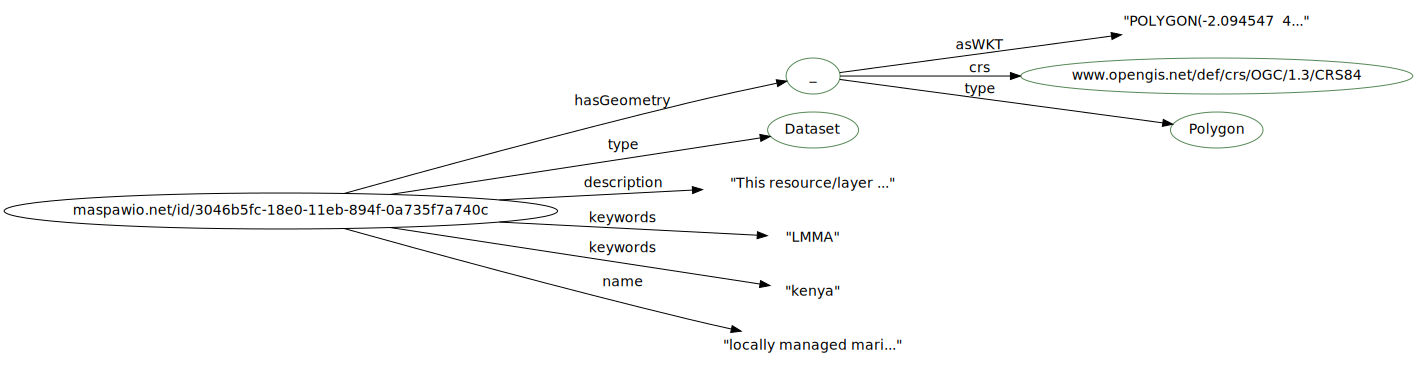

In [78]:
currentdir = os.path.dirname(os.path.abspath(''))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, currentdir)
from lib import jbutils

context = {"@vocab": "https://schema.org/", "geosparql": "http://www.opengis.net/ont/geosparql#"}
compacted = jsonld.compact(data, context)

jbutils.show_graph(compacted)

In [72]:
jd = json.dumps(compacted, indent=4)
print(jd)

{
    "@context": {
        "@vocab": "https://schema.org/",
        "geosparql": "http://www.opengis.net/ont/geosparql#"
    },
    "@id": "https://maspawio.net/id/3046b5fc-18e0-11eb-894f-0a735f7a740c",
    "geosparql:hasGeometry": {
        "@type": "http://www.opengis.net/ont/sf#Polygon",
        "geosparql:asWKT": {
            "@type": "geosparql:wktLiteral",
            "@value": "POLYGON(-2.094547  41.116223  -2.094547  39.235491 -4.674234  39.235491  -4.674234  41.116223 -2.094547 41.116223)"
        }
    },
    "description": "This resource/layer shows the spatial location of locally managed marine areas (LMMA) along the Kenyan coast. The information comes from a report done by CORDIO in 2015 that sought to review a detailed history of LMMA development in Kenya. For more information, please contact jkawaka@cordioea.net\r\n\r\n",
    "keywords": [
        "kenya",
        "LMMA"
    ],
    "name": "locally managed marine areas Kenya"
}


# Look to pull spatial data

The above works, but we lack the spatial data we want.  So, lets see what we can do there.

In [53]:
# 'POLYGON(x1 y1, x1 y2, x2 y2, x2 y1, x1 y1)'

bb = r.find('{http://www.opengis.net/ows}BoundingBox')
uc = bb.find('{http://www.opengis.net/ows}UpperCorner')
lc = bb.find('{http://www.opengis.net/ows}LowerCorner')

print("{}  {}".format(uc.text, lc.text))

ucs = uc.text.split(" ")
lcs = lc.text.split(" ")

x1 = float(ucs[0])
y1 = float(ucs[1])

x2 = float(lcs[0])
y2 = float(lcs[1])

print("{}  {}  {}  {}".format(x1, y1, x2, y2))


-2.094547 41.116223  -4.674234 39.235491
-2.094547  41.116223  -4.674234  39.235491
